In [378]:
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Importing our survey data

In [379]:
file = Path('Resources/survey_results_1.xlsx')

results_df = pd.read_excel(file)
#results_dfs

# Preprocessing

In [380]:
# renaming columns for ease of understanding
survey_df = results_df.rename(columns={
    "ID":"id",
    "Start time": "start_time",
    "Completion time": "end_time",
    "Email": "email",
    "Name": "name",	
    "What is your age range?": "age",
    "Gender":"gender",	
    "Race/Ethnicity (Select all that apply)": "race",	
    "Which US Geographic Region do you live in?": "region",	
    "What is the name of your favorite TV Show?\n": "tv_show",
    "How often do you eat vegetables?": "frequency",
    "Types of veggies you most like to eat (pick your top 5!)": "to_eat",
    'What is your "go to" choice for veggies at home? (Pick your top three)': "at_home",
    'What is your "go to" choice for veggies at a restaurant (top three)': "at_restaurant",	
    "Preferred ways for cooking/preparing the choices you selected above": "cook_prep",
    "What alternative to vegetables do you use/eat to stay healthy?": "alternatives",
    "What are your top three favorite types of fruits you like to eat? (example: apples, bananas, oranges)": "fruits"})
survey_df

,id,start_time,end_time,email,name,age,gender,race,region,tv_show,frequency,to_eat,at_home,at_restaurant,cook_prep,alternatives,fruits
0,1,2022-06-04 15:01:02,2022-06-04 15:05:26,anonymous,NaN,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Firefly,1/week,Asparagus ;Corn;Carrots;Spinach;Broccoli;,Lettuce (any kind);Carrots;Spinach;,Asparagus;Corn;Broccoli;,Grilled;Sauteed;Baked;,NaN,"Cherries, blueberries, pineapple"
1,2,2022-06-06 19:20:23,2022-06-06 19:22:18,anonymous,NaN,20-29,Female,Asian;,Midwest,Vincenzo,4-5/week,Broccoli;Cauliflower;Corn;Green Beans;Peas;Spi...,Broccoli;Corn;Peas;,Broccoli;Cauliflower;Corn;,Fried/Air-fried;Grilled;Sauteed;Microwaved;,NaN,"Mangoes, cherries, oranges"
2,3,2022-06-06 19:19:21,2022-06-06 19:22:26,anonymous,NaN,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Ted Lasso,Daily 6-7 week,Broccoli;Carrots;Green Beans;Spinach;Squash;,Broccoli;Carrots;Squash;,Lettuce (any kind);Broccoli;Spinach;,Steamed;Baked;,NaN,"bananas, strawberries, mangos"
3,4,2022-06-06 19:20:24,2022-06-06 19:25:18,anonymous,NaN,20-29,Female,Black or African American;,Midwest,Succession,2-3/week,Broccoli;Carrots;Corn;Green Beans;Cauliflower;,Broccoli;Carrots;Cauliflower;,Broccoli;Carrots;Green Beans;,Baked;Fried/Air-fried;Steamed;,NaN,"Bananas, strawberries, oranges"
4,5,2022-06-06 19:28:42,2022-06-06 19:35:54,anonymous,NaN,30-39,Female,"Caucasian, non-Hispanic;",Midwest,Critical Role,2-3/week,Carrots;Spinach;Squash;Corn;Cauliflower;,Spinach;Carrots;Broccoli;,Spinach;Carrots;Squash;,Baked;Sauteed;,NaN,"Peaches, Oranges, Mangoes"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171,2022-06-08 07:22:36,2022-06-08 07:25:52,anonymous,NaN,50-65,Female,"Caucasian, non-Hispanic;",Midwest,Chopped,2-3/week,Corn;Broccoli;Cauliflower;Carrots;,Corn;Broccoli;,Corn;Broccoli;Lettuce (any kind);,Baked;,NaN,Blueberry
171,172,2022-06-08 08:45:06,2022-06-08 08:47:29,anonymous,NaN,40-49,Male,"Caucasian, Latino/Hispanic;",Midwest,Seinfeld,4-5/week,Broccoli;Carrots;Green Beans;,Broccoli;,Lettuce (any kind);,Microwaved;,NaN,"Bananas, strawberries, kumquat"
172,173,2022-06-08 08:47:55,2022-06-08 08:50:06,anonymous,NaN,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Don't have one,Rarely (Only if someone makes me; holidays onl...,Corn;Lettuce (any kind);Spinach;Carrots;,Carrots;Corn;Lettuce (any kind);,Corn;,Steamed;,NaN,"Kiwi, mango, strawberries"
173,174,2022-06-08 21:35:14,2022-06-08 21:38:54,anonymous,NaN,50-65,Female,"Caucasian, non-Hispanic;",Midwest,Jimmy Kimmel,4-5/week,Carrots;Spinach;Broccoli;Cauliflower;Green Beans;,Carrots;Spinach;Broccoli;,Broccoli;Cauliflower;Spinach;,Sauteed;,NaN,"Bananna's, apples, oranges"


In [381]:
# this cell splits columns with multiple answers into their own columns, drops any extra answers beyond what was asked for, and names the new columns
# the result is five baby dataframes

drop_list_five = [0,1,2,3,4]
drop_list_three = [0,1,2]

# SPLIT COLUMNS WITH MULTIPLE SELECTIONS
to_eat_test = survey_df["to_eat"].str.split(';', expand = True)
at_home_test = survey_df["at_home"].str.split(';', expand = True)
at_restaurant_test = survey_df["at_restaurant"].str.split(';', expand = True)
cook_prep_test = survey_df["cook_prep"].str.split(';', expand = True)
fruits_test = survey_df["fruits"].str.split(', ', expand = True)

# drop any columns that come after our drop list
top_to_eat = to_eat_test.drop(to_eat_test.columns.difference(drop_list_five), axis = 1)
top_at_home = at_home_test.drop(at_home_test.columns.difference(drop_list_three), axis = 1)
top_at_restaurant = at_restaurant_test.drop(at_restaurant_test.columns.difference(drop_list_three), axis = 1)
top_cook_prep = cook_prep_test.drop(cook_prep_test.columns.difference(drop_list_three), axis = 1)
top_fruits = fruits_test.drop(fruits_test.columns.difference(drop_list_three), axis = 1)

# rename the new columns
top_to_eat = top_to_eat.rename(columns = {0:"to_eat_1", 1: "to_eat_2", 2: "to_eat_3", 3: "to_eat_4", 4: "to_eat_5"})
top_at_home = top_at_home.rename(columns = {0:"at_home_1", 1: "at_home_2", 2: "at_home_3"})
top_at_restaurant = top_at_restaurant.rename(columns = {0:"at_restaurant_1", 1: "at_restaurant_2", 2: "at_restaurant_3"})
top_cook_prep = top_cook_prep.rename(columns = {0:"cook_prep_1", 1: "cook_prep_2", 2: "cook_prep_3"})
top_fruits = top_fruits.rename(columns = {0:"fruits_1", 1: "fruits_2", 2: "fruits_3"})

In [382]:
# creating a list of new dataframes
df_list = [top_to_eat, top_at_home, top_at_restaurant,top_cook_prep, top_fruits]
# pd.merge(pd.merge(top_to_eat,top_at_home,on='id'),top_at_restaurant,on='id')

# merging the five new dataframes into one new dataframe
df = df_list[0]
for df_ in df_list[1:]:
    df = df.merge(df_, left_index=True, right_index=True)

# adding this new dataframe back into survey_df 
for column in df:
     
    # Select column conents by column
    # name using [] operator
    survey_df[column] = df[column]

print(survey_df.keys())

Index(['id', 'start_time', 'end_time', 'email', 'name', 'age', 'gender',
       'race', 'region', 'tv_show', 'frequency', 'to_eat', 'at_home',
       'at_restaurant', 'cook_prep', 'alternatives', 'fruits', 'to_eat_1',
       'to_eat_2', 'to_eat_3', 'to_eat_4', 'to_eat_5', 'at_home_1',
       'at_home_2', 'at_home_3', 'at_restaurant_1', 'at_restaurant_2',
       'at_restaurant_3', 'cook_prep_1', 'cook_prep_2', 'cook_prep_3',
       'fruits_1', 'fruits_2', 'fruits_3'],
      dtype='object')


In [383]:
# dropping non-beneficial columns
survey_df.drop(['start_time', 'end_time', 'email', 'name', 'alternatives', 'to_eat', 'at_home', 'at_restaurant','cook_prep', 'fruits'], axis=1, inplace=True)
survey_df

,id,age,gender,race,region,tv_show,frequency,to_eat_1,to_eat_2,to_eat_3,...,at_home_3,at_restaurant_1,at_restaurant_2,at_restaurant_3,cook_prep_1,cook_prep_2,cook_prep_3,fruits_1,fruits_2,fruits_3
0,1,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Firefly,1/week,Asparagus,Corn,Carrots,...,Spinach,Asparagus,Corn,Broccoli,Grilled,Sauteed,Baked,Cherries,blueberries,pineapple
1,2,20-29,Female,Asian;,Midwest,Vincenzo,4-5/week,Broccoli,Cauliflower,Corn,...,Peas,Broccoli,Cauliflower,Corn,Fried/Air-fried,Grilled,Sauteed,Mangoes,cherries,oranges
2,3,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Ted Lasso,Daily 6-7 week,Broccoli,Carrots,Green Beans,...,Squash,Lettuce (any kind),Broccoli,Spinach,Steamed,Baked,,bananas,strawberries,mangos
3,4,20-29,Female,Black or African American;,Midwest,Succession,2-3/week,Broccoli,Carrots,Corn,...,Cauliflower,Broccoli,Carrots,Green Beans,Baked,Fried/Air-fried,Steamed,Bananas,strawberries,oranges
4,5,30-39,Female,"Caucasian, non-Hispanic;",Midwest,Critical Role,2-3/week,Carrots,Spinach,Squash,...,Broccoli,Spinach,Carrots,Squash,Baked,Sauteed,,Peaches,Oranges,Mangoes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171,50-65,Female,"Caucasian, non-Hispanic;",Midwest,Chopped,2-3/week,Corn,Broccoli,Cauliflower,...,,Corn,Broccoli,Lettuce (any kind),Baked,,None,Blueberry,None,None
171,172,40-49,Male,"Caucasian, Latino/Hispanic;",Midwest,Seinfeld,4-5/week,Broccoli,Carrots,Green Beans,...,None,Lettuce (any kind),,None,Microwaved,,None,Bananas,strawberries,kumquat
172,173,40-49,Female,"Caucasian, non-Hispanic;",Midwest,Don't have one,Rarely (Only if someone makes me; holidays onl...,Corn,Lettuce (any kind),Spinach,...,Lettuce (any kind),Corn,,None,Steamed,,None,Kiwi,mango,strawberries
173,174,50-65,Female,"Caucasian, non-Hispanic;",Midwest,Jimmy Kimmel,4-5/week,Carrots,Spinach,Broccoli,...,Broccoli,Broccoli,Cauliflower,Spinach,Sauteed,,None,Bananna's,apples,oranges


In [384]:
# capitalizing all values
survey_df = survey_df.apply(lambda x: x.astype(str).str.upper())
survey_df

,id,age,gender,race,region,tv_show,frequency,to_eat_1,to_eat_2,to_eat_3,...,at_home_3,at_restaurant_1,at_restaurant_2,at_restaurant_3,cook_prep_1,cook_prep_2,cook_prep_3,fruits_1,fruits_2,fruits_3
0,1,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,FIREFLY,1/WEEK,ASPARAGUS,CORN,CARROTS,...,SPINACH,ASPARAGUS,CORN,BROCCOLI,GRILLED,SAUTEED,BAKED,CHERRIES,BLUEBERRIES,PINEAPPLE
1,2,20-29,FEMALE,ASIAN;,MIDWEST,VINCENZO,4-5/WEEK,BROCCOLI,CAULIFLOWER,CORN,...,PEAS,BROCCOLI,CAULIFLOWER,CORN,FRIED/AIR-FRIED,GRILLED,SAUTEED,MANGOES,CHERRIES,ORANGES
2,3,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,TED LASSO,DAILY 6-7 WEEK,BROCCOLI,CARROTS,GREEN BEANS,...,SQUASH,LETTUCE (ANY KIND),BROCCOLI,SPINACH,STEAMED,BAKED,,BANANAS,STRAWBERRIES,MANGOS
3,4,20-29,FEMALE,BLACK OR AFRICAN AMERICAN;,MIDWEST,SUCCESSION,2-3/WEEK,BROCCOLI,CARROTS,CORN,...,CAULIFLOWER,BROCCOLI,CARROTS,GREEN BEANS,BAKED,FRIED/AIR-FRIED,STEAMED,BANANAS,STRAWBERRIES,ORANGES
4,5,30-39,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CRITICAL ROLE,2-3/WEEK,CARROTS,SPINACH,SQUASH,...,BROCCOLI,SPINACH,CARROTS,SQUASH,BAKED,SAUTEED,,PEACHES,ORANGES,MANGOES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171,50-65,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CHOPPED,2-3/WEEK,CORN,BROCCOLI,CAULIFLOWER,...,,CORN,BROCCOLI,LETTUCE (ANY KIND),BAKED,,NONE,BLUEBERRY,NONE,NONE
171,172,40-49,MALE,"CAUCASIAN, LATINO/HISPANIC;",MIDWEST,SEINFELD,4-5/WEEK,BROCCOLI,CARROTS,GREEN BEANS,...,NONE,LETTUCE (ANY KIND),,NONE,MICROWAVED,,NONE,BANANAS,STRAWBERRIES,KUMQUAT
172,173,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,DON'T HAVE ONE,RARELY (ONLY IF SOMEONE MAKES ME; HOLIDAYS ONL...,CORN,LETTUCE (ANY KIND),SPINACH,...,LETTUCE (ANY KIND),CORN,,NONE,STEAMED,,NONE,KIWI,MANGO,STRAWBERRIES
173,174,50-65,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,JIMMY KIMMEL,4-5/WEEK,CARROTS,SPINACH,BROCCOLI,...,BROCCOLI,BROCCOLI,CAULIFLOWER,SPINACH,SAUTEED,,NONE,BANANNA'S,APPLES,ORANGES


In [385]:
# doing some manual cleaning on fruits
survey_df['fruits_1'] = survey_df['fruits_1'].replace(
    ['BANANA', 'MANGO', 'MANGOES', 'STRAWBERRY', 'APPLE', 'BLUE BERRIES', 'BLUEBERRY', 'PEACH', 'APPLE’S', ' APPLES', 'ORANGE', 'PEAR', 'CLEMENTINE', 'MANDERIN ORANGES', 'TANGERINES', 'RAINER CHERRIES', 'RED GRAPES', 'CLEMENTINES', 'RASPBERRY ', '(NAVEL) ORANGES', 'APPLE', 'BLUEBERRY', 'BLUEBERR', "BANANNA'S", ' MANGO', 'BLACKBERRY', 'PINEAPPLES', 'MANDARINS', 'WATER MELON ', 'HONEYDEW (ANY) MELONS', 'TOMATO', 'POMEGRANATE', 'RASPBERRY'], 
    ['BANANAS', 'MANGOS', 'MANGOS', 'STRAWBERRIES', 'APPLES', 'BLUEBERRIES', 'BLUEBERRIES', 'PEACHES', 'APPLES', 'APPLES', 'ORANGES', 'PEARS', 'ORANGES', 'ORANGES', 'ORANGES', 'CHERRIES', 'GRAPES', 'ORANGES', 'RASPBERRIES', 'ORANGES', 'APPLES', 'BLUEBERIES', 'BLUEBERIES', 'BANANAS', 'MANGOS', 'BLACKBERRIES', 'PINEAPPLE', 'ORANGES', 'WATERMELON', 'MELON', 'TOMATOES', 'POMEGRANATES', 'RASPBERRIES'])

survey_df['fruits_2'] = survey_df['fruits_2'].replace(
    ['BANANA', 'MANGO', 'MANGOES', 'STRAWBERRY', 'APPLE', 'BLUE BERRIES', 'BLUEBERRY', 'PEACH', 'APPLE’S', ' APPLES', 'ORANGE', 'PEAR', 'CLEMENTINE', 'MANDERIN ORANGES', 'TANGERINES', 'RAINER CHERRIES', 'RED GRAPES', 'CLEMENTINES', 'RASPBERRY ', '(NAVEL) ORANGES','APPLE', 'BLUEBERRY', 'BLUEBERR', "BANANNA'S", ' MANGO', 'BLACKBERRY', 'PINEAPPLES', 'MANDARINS', 'WATER MELON ', 'HONEYDEW (ANY) MELONS', 'TOMATO', 'POMEGRANATE', 'RASPBERRY'], 
    ['BANANAS', 'MANGOS', 'MANGOS', 'STRAWBERRIES', 'APPLES', 'BLUEBERRIES', 'BLUEBERRIES', 'PEACHES', 'APPLES', 'APPLES', 'ORANGES', 'PEARS', 'ORANGES', 'ORANGES', 'ORANGES', 'CHERRIES', 'GRAPES', 'ORANGES', 'RASPBERRIES', 'ORANGES', 'APPLES', 'BLUEBERIES', 'BLUEBERIES', 'BANANAS', 'MANGOS', 'BLACKBERRIES', 'PINEAPPLE', 'ORANGES', 'WATERMELON', 'MELON', 'TOMATOES', 'POMEGRANATES', 'RASPBERRIES'])

survey_df['fruits_3'] = survey_df['fruits_3'].replace(
    ['BANANA', 'MANGO', 'MANGOES', 'STRAWBERRY', 'APPLE', 'BLUE BERRIES', 'BLUEBERRY', 'PEACH', 'APPLE’S', ' APPLES', 'ORANGE', 'PEAR', 'CLEMENTINE', 'MANDERIN ORANGES', 'TANGERINES', 'RAINER CHERRIES', 'RED GRAPES', 'CLEMENTINES', 'RASPBERRY ', '(NAVEL) ORANGES','APPLE', 'BLUEBERRY', 'BLUEBERR', "BANANNA'S", ' MANGO', 'BLACKBERRY', 'PINEAPPLES', 'MANDARINS', 'WATER MELON ', 'HONEYDEW (ANY) MELONS', 'TOMATO', 'POMEGRANATE', 'RASPBERRY'], 
    ['BANANAS', 'MANGOS', 'MANGOS', 'STRAWBERRIES', 'APPLES', 'BLUEBERRIES', 'BLUEBERRIES', 'PEACHES', 'APPLES', 'APPLES', 'ORANGES', 'PEARS', 'ORANGES', 'ORANGES', 'ORANGES', 'CHERRIES', 'GRAPES', 'ORANGES', 'RASPBERRIES', 'ORANGES', 'APPLES', 'BLUEBERIES', 'BLUEBERIES', 'BANANAS', 'MANGOS', 'BLACKBERRIES', 'PINEAPPLE', 'ORANGES', 'WATERMELON', 'MELON', 'TOMATOES', 'POMEGRANATES', 'RASPBERRIES'])


In [386]:
# determine the number of unique values in each column
survey_cat = survey_df.dtypes.index.tolist()
survey_df[survey_cat].nunique()

id                 175
age                  7
gender               3
race                11
region              10
tv_show            129
frequency            5
to_eat_1            14
to_eat_2            12
to_eat_3            16
to_eat_4            24
to_eat_5            31
at_home_1           18
at_home_2           16
at_home_3           25
at_restaurant_1     20
at_restaurant_2     16
at_restaurant_3     25
cook_prep_1         11
cook_prep_2         10
cook_prep_3         12
fruits_1            22
fruits_2            30
fruits_3            27
dtype: int64

In [387]:
# look at fruits_1 value counts for binning
fruits_1_count = survey_df['fruits_1'].value_counts()
fruits_1_count

BANANAS          37
APPLES           32
STRAWBERRIES     19
BLUEBERRIES      13
GRAPES           12
MANGOS           12
ORANGES          10
PINEAPPLE         7
WATERMELON        5
BLUEBERIES        4
BLACKBERRIES      4
RASPBERRIES       3
BERRIES           3
CHERRIES          3
PEACHES           2
GRAPEFRUIT        2
KIWI              2
POMEGRANATES      1
GRADED            1
I AM DIABETIC     1
MELON             1
NONE              1
Name: fruits_1, dtype: int64

In [388]:
# bin all the fruits that have just 1 response together into "other"
fruits_1_to_replace = list(fruits_1_count[fruits_1_count == 1].index)

# replace in dataframe
for fruit in fruits_1_to_replace:
    survey_df['fruits_1'] = survey_df['fruits_1'].replace(fruit, "OTHER")

# check to make sure binning was successful
survey_df['fruits_1'].value_counts()

BANANAS         37
APPLES          32
STRAWBERRIES    19
BLUEBERRIES     13
GRAPES          12
MANGOS          12
ORANGES         10
PINEAPPLE        7
WATERMELON       5
OTHER            5
BLUEBERIES       4
BLACKBERRIES     4
BERRIES          3
CHERRIES         3
RASPBERRIES      3
PEACHES          2
GRAPEFRUIT       2
KIWI             2
Name: fruits_1, dtype: int64

In [389]:
# look at fruits_2 value counts for binning
fruits_2_count = survey_df['fruits_2'].value_counts()
fruits_2_count.head(30)

GRAPES                                 19
APPLES                                 19
STRAWBERRIES                           17
BANANAS                                17
BLUEBERRIES                            13
ORANGES                                13
MANGOS                                 12
WATERMELON                             11
PINEAPPLE                               8
NONE                                    7
RASPBERRIES                             6
PEACHES                                 4
CHERRIES                                4
MELON                                   3
PEARS                                   3
CANTELOPE                               2
GRAPEFRUIT                              2
TOMATOES                                2
BLACKBERRIES                            2
RASBERRIES                              1
CANTALOUPE                              1
SO FRUIT HAS TOO MUCH SUGAR FOR ME.     1
DATES                                   1
PAPAYA                            

In [390]:
# bin all the fruits that have just 1 response together into "other"
fruits_2_to_replace = list(fruits_2_count[fruits_2_count == 1].index)

# replace in dataframe
for fruit in fruits_2_to_replace:
    survey_df['fruits_2'] = survey_df['fruits_2'].replace(fruit, "OTHER")

# check to make sure binning was successful
survey_df['fruits_2'].value_counts()

GRAPES          19
APPLES          19
STRAWBERRIES    17
BANANAS         17
BLUEBERRIES     13
ORANGES         13
MANGOS          12
WATERMELON      11
OTHER           11
PINEAPPLE        8
NONE             7
RASPBERRIES      6
CHERRIES         4
PEACHES          4
PEARS            3
MELON            3
GRAPEFRUIT       2
CANTELOPE        2
TOMATOES         2
BLACKBERRIES     2
Name: fruits_2, dtype: int64

In [391]:
# look at fruits_3 value counts for binning
fruits_3_count = survey_df['fruits_3'].value_counts()
fruits_3_count.head(30)

GRAPES          26
BANANAS         22
STRAWBERRIES    15
ORANGES         15
APPLES          15
NONE            11
WATERMELON      10
PINEAPPLE        9
BLUEBERRIES      8
KIWI             6
MANGOS           5
RASPBERRIES      5
PEACHES          5
CHERRIES         4
BLACKBERRIES     3
GRAPEFRUIT       2
BERRIES          2
MELON            2
POMEGRANATES     2
LEMON            1
CANTALOUPE       1
PLUMS            1
CANTELOPE        1
JACK FRUIT       1
NECTARINES       1
LIMES            1
KUMQUAT          1
Name: fruits_3, dtype: int64

In [392]:
# bin all the fruits that have just 1 response together into "other"
fruits_3_to_replace = list(fruits_3_count[fruits_3_count == 1].index)

# replace in dataframe
for fruit in fruits_3_to_replace:
    survey_df['fruits_3'] = survey_df['fruits_3'].replace(fruit, "OTHER")

# check to make sure binning was successful
survey_df['fruits_3'].value_counts()

GRAPES          26
BANANAS         22
STRAWBERRIES    15
APPLES          15
ORANGES         15
NONE            11
WATERMELON      10
PINEAPPLE        9
OTHER            8
BLUEBERRIES      8
KIWI             6
RASPBERRIES      5
MANGOS           5
PEACHES          5
CHERRIES         4
BLACKBERRIES     3
POMEGRANATES     2
BERRIES          2
MELON            2
GRAPEFRUIT       2
Name: fruits_3, dtype: int64

In [393]:
# doing some manual cleaning on to_eat
survey_df['to_eat_1'] = survey_df['to_eat_1'].replace(
    ['RED PEPPER', ' CUCUMBER', 'BELL PEPPER', 'BRUSSEL SPROUTS', 'LETTUCE - BUT ONLY "NORMAL" LETTUCE (ICEBERG OR ROMAINE)', 'CUCUMBER', 'PEPPERS GREEN, ORANGE, YELLOW', 'TOMATO', 'GREEN PEPPER', 'BEATS'], 
    ['BELL PEPPERS', 'CUCUMBERS', 'BELL PEPPERS', 'BRUSSELS SPROUTS', 'LETTUCE (ANY KIND)', 'CUCUMBERS', 'BELL PEPPERS', 'TOMATOES', 'BELL PEPPERS', 'BEETS'])

survey_df['to_eat_2'] = survey_df['to_eat_2'].replace(
    ['RED PEPPER', ' CUCUMBER', 'BELL PEPPER', 'BRUSSEL SPROUTS', 'LETTUCE - BUT ONLY "NORMAL" LETTUCE (ICEBERG OR ROMAINE)', 'CUCUMBER', 'PEPPERS GREEN, ORANGE, YELLOW', 'TOMATO', 'GREEN PEPPER', 'BEATS'], 
    ['BELL PEPPERS', 'CUCUMBERS', 'BELL PEPPERS', 'BRUSSELS SPROUTS', 'LETTUCE (ANY KIND)', 'CUCUMBERS', 'BELL PEPPERS', 'TOMATOES', 'BELL PEPPERS', 'BEETS'])

survey_df['to_eat_3'] = survey_df['to_eat_3'].replace(
    ['RED PEPPER', ' CUCUMBER', 'BELL PEPPER', 'BRUSSEL SPROUTS', 'LETTUCE - BUT ONLY "NORMAL" LETTUCE (ICEBERG OR ROMAINE)', 'CUCUMBER', 'PEPPERS GREEN, ORANGE, YELLOW', 'TOMATO', 'GREEN PEPPER', 'BEATS'], 
    ['BELL PEPPERS', 'CUCUMBERS', 'BELL PEPPERS', 'BRUSSELS SPROUTS', 'LETTUCE (ANY KIND)', 'CUCUMBERS', 'BELL PEPPERS', 'TOMATOES', 'BELL PEPPERS', 'BEETS'])

survey_df['to_eat_4'] = survey_df['to_eat_4'].replace(
    ['RED PEPPER', ' CUCUMBER', 'BELL PEPPER', 'BRUSSEL SPROUTS', 'LETTUCE - BUT ONLY "NORMAL" LETTUCE (ICEBERG OR ROMAINE)', 'CUCUMBER', 'PEPPERS GREEN, ORANGE, YELLOW', 'TOMATO', 'GREEN PEPPER', 'BEATS'], 
    ['BELL PEPPERS', 'CUCUMBERS', 'BELL PEPPERS', 'BRUSSELS SPROUTS', 'LETTUCE (ANY KIND)', 'CUCUMBERS', 'BELL PEPPERS', 'TOMATOES', 'BELL PEPPERS', 'BEETS'])

survey_df['to_eat_5'] = survey_df['to_eat_5'].replace(
    ['RED PEPPER', ' CUCUMBER', 'BELL PEPPER', 'BRUSSEL SPROUTS', 'LETTUCE - BUT ONLY "NORMAL" LETTUCE (ICEBERG OR ROMAINE)', 'CUCUMBER', 'PEPPERS GREEN, ORANGE, YELLOW', 'TOMATO', 'GREEN PEPPER', 'BEATS'], 
    ['BELL PEPPERS', 'CUCUMBERS', 'BELL PEPPERS', 'BRUSSELS SPROUTS', 'LETTUCE (ANY KIND)', 'CUCUMBERS', 'BELL PEPPERS', 'TOMATOES', 'BELL PEPPERS', 'BEETS'])


In [394]:
# look at to_eat_1 value counts for binning
to_eat_1_count = survey_df['to_eat_1'].value_counts()
to_eat_1_count

BROCCOLI              81
CARROTS               24
SPINACH               15
CORN                  15
LETTUCE (ANY KIND)    13
GREEN BEANS            9
PEAS                   5
CAULIFLOWER            5
SQUASH                 3
ASPARAGUS              1
SAUERKRAUT/CABBAGE     1
CABBAGE                1
EGGPLANT               1
CUCUMBERS              1
Name: to_eat_1, dtype: int64

# should we bin any to_eat_1 items? should we put sauerkraut with cabbage?

In [395]:
# look at to_eat_2 value counts for binning
to_eat_2_count = survey_df['to_eat_2'].value_counts()
to_eat_2_count

CARROTS               45
CAULIFLOWER           25
CORN                  22
GREEN BEANS           22
LETTUCE (ANY KIND)    20
BROCCOLI              16
SPINACH               12
PEAS                   6
                       3
SQUASH                 2
BRUSSELS SPROUTS       1
BELL PEPPERS           1
Name: to_eat_2, dtype: int64

# should we bin any to_eat_2 items? There are some blanks...

In [396]:
# look at to_eat_3 value counts for binning
to_eat_3_count = survey_df['to_eat_3'].value_counts()
to_eat_3_count

LETTUCE (ANY KIND)    33
CORN                  27
CARROTS               22
GREEN BEANS           22
SPINACH               18
CAULIFLOWER           16
BROCCOLI              14
PEAS                   6
SQUASH                 5
                       4
NONE                   3
CUCUMBERS              2
TOMATOES               1
ASPARAGUS              1
BEETS                  1
Name: to_eat_3, dtype: int64

# should we bin any to_eat_3 items? There are some blanks and some nones... put them together?

In [397]:
# look at to_eat_4 value counts for binning
to_eat_4_count = survey_df['to_eat_4'].value_counts()
to_eat_4_count

SPINACH               25
LETTUCE (ANY KIND)    22
GREEN BEANS           21
CORN                  18
CARROTS               16
SQUASH                12
CAULIFLOWER           11
                      10
BROCCOLI               9
PEAS                   8
NONE                   7
BELL PEPPERS           4
TOMATOES               2
RADISH                 2
ASPARAGUS              2
BEETS                  1
ONIONS                 1
BRUSSELS SPROUTS       1
CUCUMBERS              1
EGGPLANT               1
SWEET POTATOES         1
Name: to_eat_4, dtype: int64

# should we bin any to_eat_4 items? Blanks and nones... 
## Remove the "CORN IS A GRAIN, NOT A VEGETABLE" RESPONSE

In [398]:
# look at to_eat_5 value counts for binning
to_eat_5_count = survey_df['to_eat_5'].value_counts()
to_eat_5_count

GREEN BEANS                         20
NONE                                17
SPINACH                             16
PEAS                                15
                                    15
SQUASH                              13
CORN                                13
LETTUCE (ANY KIND)                  11
ASPARAGUS                           10
CAULIFLOWER                          9
BRUSSELS SPROUTS                     7
CARROTS                              6
BROCCOLI                             5
CUCUMBERS                            4
TOMATOES                             2
BELL PEPPERS                         2
POTATOES                             1
PINTO BEANS                          1
OKRA                                 1
CORN IS A GRAIN, NOT A VEGETABLE     1
CELERY                               1
BAKED BEANS                          1
ONIONS                               1
COLLARD GREENS                       1
EGGPLANT                             1
BLACK BEANS              

# should we bin any to_eat_5 items? Blanks and nones, corn is a grain...

In [399]:
survey_df

,id,age,gender,race,region,tv_show,frequency,to_eat_1,to_eat_2,to_eat_3,...,at_home_3,at_restaurant_1,at_restaurant_2,at_restaurant_3,cook_prep_1,cook_prep_2,cook_prep_3,fruits_1,fruits_2,fruits_3
0,1,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,FIREFLY,1/WEEK,ASPARAGUS,CORN,CARROTS,...,SPINACH,ASPARAGUS,CORN,BROCCOLI,GRILLED,SAUTEED,BAKED,CHERRIES,BLUEBERRIES,PINEAPPLE
1,2,20-29,FEMALE,ASIAN;,MIDWEST,VINCENZO,4-5/WEEK,BROCCOLI,CAULIFLOWER,CORN,...,PEAS,BROCCOLI,CAULIFLOWER,CORN,FRIED/AIR-FRIED,GRILLED,SAUTEED,MANGOS,CHERRIES,ORANGES
2,3,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,TED LASSO,DAILY 6-7 WEEK,BROCCOLI,CARROTS,GREEN BEANS,...,SQUASH,LETTUCE (ANY KIND),BROCCOLI,SPINACH,STEAMED,BAKED,,BANANAS,STRAWBERRIES,MANGOS
3,4,20-29,FEMALE,BLACK OR AFRICAN AMERICAN;,MIDWEST,SUCCESSION,2-3/WEEK,BROCCOLI,CARROTS,CORN,...,CAULIFLOWER,BROCCOLI,CARROTS,GREEN BEANS,BAKED,FRIED/AIR-FRIED,STEAMED,BANANAS,STRAWBERRIES,ORANGES
4,5,30-39,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CRITICAL ROLE,2-3/WEEK,CARROTS,SPINACH,SQUASH,...,BROCCOLI,SPINACH,CARROTS,SQUASH,BAKED,SAUTEED,,PEACHES,ORANGES,MANGOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171,50-65,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CHOPPED,2-3/WEEK,CORN,BROCCOLI,CAULIFLOWER,...,,CORN,BROCCOLI,LETTUCE (ANY KIND),BAKED,,NONE,BLUEBERIES,NONE,NONE
171,172,40-49,MALE,"CAUCASIAN, LATINO/HISPANIC;",MIDWEST,SEINFELD,4-5/WEEK,BROCCOLI,CARROTS,GREEN BEANS,...,NONE,LETTUCE (ANY KIND),,NONE,MICROWAVED,,NONE,BANANAS,STRAWBERRIES,OTHER
172,173,40-49,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,DON'T HAVE ONE,RARELY (ONLY IF SOMEONE MAKES ME; HOLIDAYS ONL...,CORN,LETTUCE (ANY KIND),SPINACH,...,LETTUCE (ANY KIND),CORN,,NONE,STEAMED,,NONE,KIWI,MANGOS,STRAWBERRIES
173,174,50-65,FEMALE,"CAUCASIAN, NON-HISPANIC;",MIDWEST,JIMMY KIMMEL,4-5/WEEK,CARROTS,SPINACH,BROCCOLI,...,BROCCOLI,BROCCOLI,CAULIFLOWER,SPINACH,SAUTEED,,NONE,BANANAS,APPLES,ORANGES


In [400]:
# re-look at the number of unique values in each column now that the fruits have been binned
survey_cat = survey_df.dtypes.index.tolist()
survey_df[survey_cat].nunique()

id                 175
age                  7
gender               3
race                11
region              10
tv_show            129
frequency            5
to_eat_1            14
to_eat_2            12
to_eat_3            15
to_eat_4            21
to_eat_5            26
at_home_1           18
at_home_2           16
at_home_3           25
at_restaurant_1     20
at_restaurant_2     16
at_restaurant_3     25
cook_prep_1         11
cook_prep_2         10
cook_prep_3         12
fruits_1            18
fruits_2            20
fruits_3            20
dtype: int64

In [401]:
# make sure there are no null values
for column in survey_df.columns:
    print(f"Column {column} has {survey_df[column].isnull().sum()} null values")

Column id has 0 null values
Column age has 0 null values
Column gender has 0 null values
Column race has 0 null values
Column region has 0 null values
Column tv_show has 0 null values
Column frequency has 0 null values
Column to_eat_1 has 0 null values
Column to_eat_2 has 0 null values
Column to_eat_3 has 0 null values
Column to_eat_4 has 0 null values
Column to_eat_5 has 0 null values
Column at_home_1 has 0 null values
Column at_home_2 has 0 null values
Column at_home_3 has 0 null values
Column at_restaurant_1 has 0 null values
Column at_restaurant_2 has 0 null values
Column at_restaurant_3 has 0 null values
Column cook_prep_1 has 0 null values
Column cook_prep_2 has 0 null values
Column cook_prep_3 has 0 null values
Column fruits_1 has 0 null values
Column fruits_2 has 0 null values
Column fruits_3 has 0 null values


## Should we add "NaN" to the blank cells? 

In [402]:
# look at gender value counts 
gender_count = survey_df['gender'].value_counts()
gender_count

FEMALE    133
MALE       41
TREE        1
Name: gender, dtype: int64

In [403]:
# transform the gender column
def changeStatus(status):
    if status == "FEMALE":
        return 1
    if status == "MALE":
        return 0
    else:
        return 3

# Along with replace() and map(), this is another way to encode the gender column into numbers.
survey_df["gender"] = survey_df["gender"].apply(changeStatus)
survey_df

,id,age,gender,race,region,tv_show,frequency,to_eat_1,to_eat_2,to_eat_3,...,at_home_3,at_restaurant_1,at_restaurant_2,at_restaurant_3,cook_prep_1,cook_prep_2,cook_prep_3,fruits_1,fruits_2,fruits_3
0,1,40-49,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,FIREFLY,1/WEEK,ASPARAGUS,CORN,CARROTS,...,SPINACH,ASPARAGUS,CORN,BROCCOLI,GRILLED,SAUTEED,BAKED,CHERRIES,BLUEBERRIES,PINEAPPLE
1,2,20-29,1,ASIAN;,MIDWEST,VINCENZO,4-5/WEEK,BROCCOLI,CAULIFLOWER,CORN,...,PEAS,BROCCOLI,CAULIFLOWER,CORN,FRIED/AIR-FRIED,GRILLED,SAUTEED,MANGOS,CHERRIES,ORANGES
2,3,40-49,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,TED LASSO,DAILY 6-7 WEEK,BROCCOLI,CARROTS,GREEN BEANS,...,SQUASH,LETTUCE (ANY KIND),BROCCOLI,SPINACH,STEAMED,BAKED,,BANANAS,STRAWBERRIES,MANGOS
3,4,20-29,1,BLACK OR AFRICAN AMERICAN;,MIDWEST,SUCCESSION,2-3/WEEK,BROCCOLI,CARROTS,CORN,...,CAULIFLOWER,BROCCOLI,CARROTS,GREEN BEANS,BAKED,FRIED/AIR-FRIED,STEAMED,BANANAS,STRAWBERRIES,ORANGES
4,5,30-39,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CRITICAL ROLE,2-3/WEEK,CARROTS,SPINACH,SQUASH,...,BROCCOLI,SPINACH,CARROTS,SQUASH,BAKED,SAUTEED,,PEACHES,ORANGES,MANGOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171,50-65,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,CHOPPED,2-3/WEEK,CORN,BROCCOLI,CAULIFLOWER,...,,CORN,BROCCOLI,LETTUCE (ANY KIND),BAKED,,NONE,BLUEBERIES,NONE,NONE
171,172,40-49,0,"CAUCASIAN, LATINO/HISPANIC;",MIDWEST,SEINFELD,4-5/WEEK,BROCCOLI,CARROTS,GREEN BEANS,...,NONE,LETTUCE (ANY KIND),,NONE,MICROWAVED,,NONE,BANANAS,STRAWBERRIES,OTHER
172,173,40-49,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,DON'T HAVE ONE,RARELY (ONLY IF SOMEONE MAKES ME; HOLIDAYS ONL...,CORN,LETTUCE (ANY KIND),SPINACH,...,LETTUCE (ANY KIND),CORN,,NONE,STEAMED,,NONE,KIWI,MANGOS,STRAWBERRIES
173,174,50-65,1,"CAUCASIAN, NON-HISPANIC;",MIDWEST,JIMMY KIMMEL,4-5/WEEK,CARROTS,SPINACH,BROCCOLI,...,BROCCOLI,BROCCOLI,CAULIFLOWER,SPINACH,SAUTEED,,NONE,BANANAS,APPLES,ORANGES


In [404]:
survey_df_columns = survey_df.columns.values.tolist()
survey_df_columns.remove('gender')
survey_df_columns

['id',
 'age',
 'race',
 'region',
 'tv_show',
 'frequency',
 'to_eat_1',
 'to_eat_2',
 'to_eat_3',
 'to_eat_4',
 'to_eat_5',
 'at_home_1',
 'at_home_2',
 'at_home_3',
 'at_restaurant_1',
 'at_restaurant_2',
 'at_restaurant_3',
 'cook_prep_1',
 'cook_prep_2',
 'cook_prep_3',
 'fruits_1',
 'fruits_2',
 'fruits_3']

# I think we want to remove 'id' from get_dummies

In [405]:
# Convert categorical data to numeric with `pd.get_dummies`
numeric_survey_df = pd.get_dummies(survey_df)
numeric_survey_df

,gender,id_1,id_10,id_100,id_101,id_102,id_103,id_104,id_105,id_106,...,fruits_3_MELON,fruits_3_NONE,fruits_3_ORANGES,fruits_3_OTHER,fruits_3_PEACHES,fruits_3_PINEAPPLE,fruits_3_POMEGRANATES,fruits_3_RASPBERRIES,fruits_3_STRAWBERRIES,fruits_3_WATERMELON
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
172,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
173,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [406]:
# survey_df['age'] = survey_df['age'].astype('float128')

In [407]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(numeric_survey_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.head()

,k,inertia
0,1,3307.040000
1,2,3178.800113
2,3,3100.910447
3,4,3056.200185
4,5,3042.877341


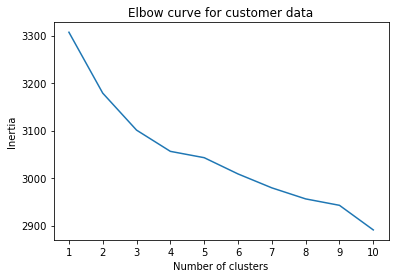

In [408]:
# Plot the elbow curve to find the best candidate(s) for k
plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow curve for customer data')
plt.show()

In [409]:
# get_clusters function
model = KMeans(n_clusters=3, random_state=0)
model.fit(numeric_survey_df)
predictions = model.predict(numeric_survey_df)
numeric_survey_df_classed = numeric_survey_df
numeric_survey_df_classed

,gender,id_1,id_10,id_100,id_101,id_102,id_103,id_104,id_105,id_106,...,fruits_3_MELON,fruits_3_NONE,fruits_3_ORANGES,fruits_3_OTHER,fruits_3_PEACHES,fruits_3_PINEAPPLE,fruits_3_POMEGRANATES,fruits_3_RASPBERRIES,fruits_3_STRAWBERRIES,fruits_3_WATERMELON
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
172,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
173,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [410]:
def get_clusters(k, data):
    # Initialize the K-Means model
    model = KMeans(n_clusters=k, random_state=0)

    # Train the model
    model.fit(data)

    # Predict clusters
    predictions = model.predict(data)

    # Create return DataFrame with predicted clusters
    data["class"] = model.labels_

    return data

In [411]:
clusters = get_clusters(3, numeric_survey_df)
clusters

,gender,id_1,id_10,id_100,id_101,id_102,id_103,id_104,id_105,id_106,...,fruits_3_NONE,fruits_3_ORANGES,fruits_3_OTHER,fruits_3_PEACHES,fruits_3_PINEAPPLE,fruits_3_POMEGRANATES,fruits_3_RASPBERRIES,fruits_3_STRAWBERRIES,fruits_3_WATERMELON,class
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
171,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
172,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
173,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


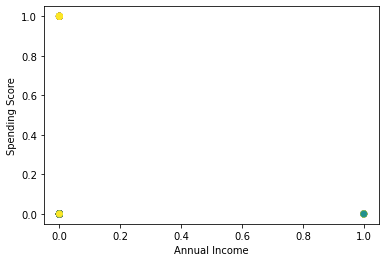

In [412]:
def show_clusters(df):
    plt.scatter(df['fruits_3_ORANGES'], df['fruits_3_APPLES'], c=df['class'])
    plt.xlabel('Annual Income')
    plt.ylabel('Spending Score')
    plt.show()

show_clusters(clusters)

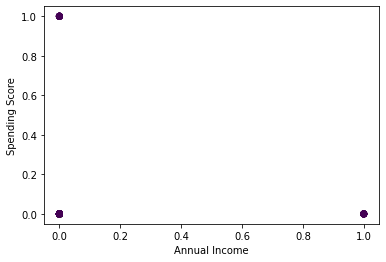

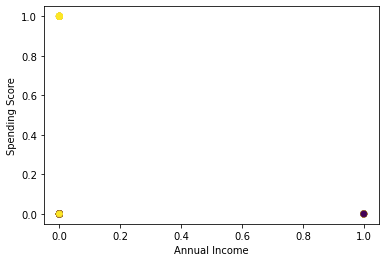

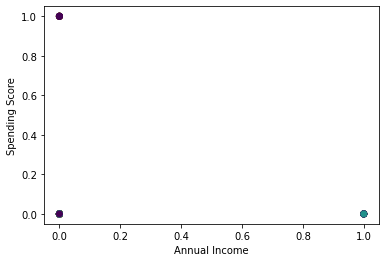

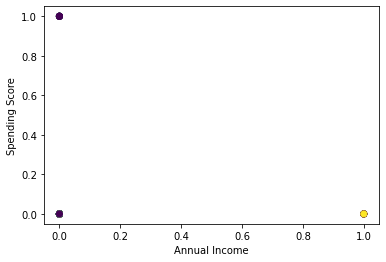

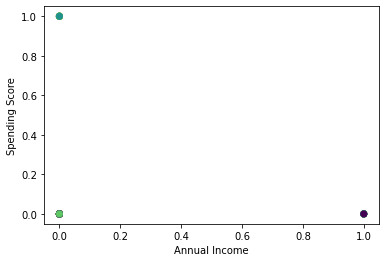

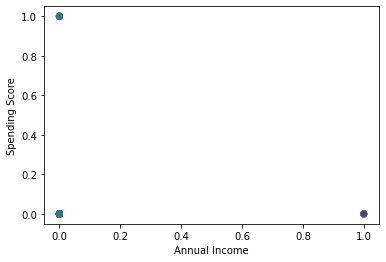

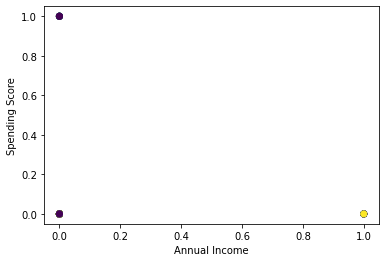

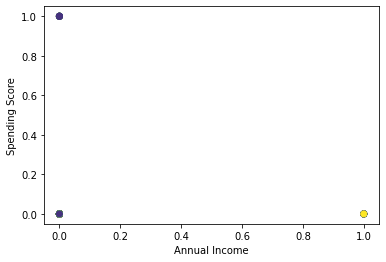

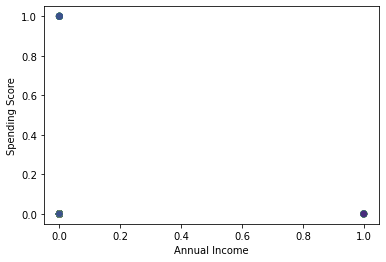

In [413]:
for k in range(1, 10):
    show_clusters(get_clusters(k, numeric_survey_df))

In [414]:
# UNIQUE VEGETABLES FROM FAVORITES TO EAT
veggie_list = []

for veggie in survey_df['to_eat_1'].unique():
    if veggie not in veggie_list:
        veggie_list.append(veggie)
for veggie in survey_df['to_eat_2'].unique():
    if veggie not in veggie_list:
        veggie_list.append(veggie)
for veggie in survey_df['to_eat_3'].unique():
    if veggie not in veggie_list:
        veggie_list.append(veggie)
for veggie in survey_df['to_eat_4'].unique():
    if veggie not in veggie_list:
        veggie_list.append(veggie)
for veggie in survey_df['to_eat_5'].unique():
    if veggie not in veggie_list:
        veggie_list.append(veggie)
veggie_list
len(veggie_list)

33

In [415]:
veggie_list = pd.DataFrame(veggie_list)

veggie_list['veggie_name'] = veggie_list[0]
test = []
for i in range(0,len(veggie_list)):
    test.append(i+1)

veggie_list

veggie_list['veg_id'] = test

veggie_list

,0,veggie_name,veg_id
0,ASPARAGUS,ASPARAGUS,1
1,BROCCOLI,BROCCOLI,2
2,CARROTS,CARROTS,3
3,SPINACH,SPINACH,4
4,CORN,CORN,5
5,LETTUCE (ANY KIND),LETTUCE (ANY KIND),6
6,SAUERKRAUT/CABBAGE,SAUERKRAUT/CABBAGE,7
7,PEAS,PEAS,8
8,GREEN BEANS,GREEN BEANS,9
9,CABBAGE,CABBAGE,10


### Data Preparation for Collaborative Filtering

In [416]:
# IMPORT FAST AI DEPENDENCIES
from fastai.collab import CollabDataBunch, collab_learner

#Utility to create tensor
from fastai.torch_core import tensor

In [417]:
survey_subset = survey_df[['id','to_eat_1', 'to_eat_2', 'to_eat_3','to_eat_4','to_eat_5']]
survey_subset

,id,to_eat_1,to_eat_2,to_eat_3,to_eat_4,to_eat_5
0,1,ASPARAGUS,CORN,CARROTS,SPINACH,BROCCOLI
1,2,BROCCOLI,CAULIFLOWER,CORN,GREEN BEANS,PEAS
2,3,BROCCOLI,CARROTS,GREEN BEANS,SPINACH,SQUASH
3,4,BROCCOLI,CARROTS,CORN,GREEN BEANS,CAULIFLOWER
4,5,CARROTS,SPINACH,SQUASH,CORN,CAULIFLOWER
...,...,...,...,...,...,...
170,171,CORN,BROCCOLI,CAULIFLOWER,CARROTS,
171,172,BROCCOLI,CARROTS,GREEN BEANS,,NONE
172,173,CORN,LETTUCE (ANY KIND),SPINACH,CARROTS,
173,174,CARROTS,SPINACH,BROCCOLI,CAULIFLOWER,GREEN BEANS


In [418]:
#Creating dataframe for collaborative filtering
survey = pd.melt(survey_subset, id_vars=['id'], 
                   var_name="value", 
                  value_name="veggie")
survey = survey.sort_values(['id'])
survey = survey.drop('value',axis=1)
survey

survey = pd.merge(survey,veggie_list,left_on='veggie',right_on='veggie_name')
survey = survey[['id','veg_id']]
survey['like'] = 1
survey


,id,veg_id,like
0,1,1,1
1,1,3,1
2,10,3,1
3,103,3,1
4,104,3,1
...,...,...,...
870,71,22,1
871,90,22,1
872,75,23,1
873,92,26,1


In [419]:
#Creating dataframe with to indicate which veggies weren't in a user's top 5 (like=0)
z_user = []
z_veg = []
# data_zero = []
for user in survey['id'].unique():
    for veg in veggie_list['veg_id']:
        if veg not in survey['veg_id'][survey['id']==user].to_list():
            z_user.append(user)
            z_veg.append(veg)

zeros = pd.DataFrame()
zeros['id'] = z_user
zeros['veg_id'] = z_veg
zeros['like'] = 0
zeros

,id,veg_id,like
0,1,6,0
1,1,7,0
2,1,8,0
3,1,9,0
4,1,10,0
...,...,...,...
4905,17,29,0
4906,17,30,0
4907,17,31,0
4908,17,32,0


In [420]:
import random

In [421]:
#Viewing shape of the survey results to ensure that df created for 0s matches
survey.shape
zeros.shape

lr = range(1,zeros.shape[0])
needed_rows = survey.shape[0]
random.choices(lr, k=3)

# Using random generator to select an equal number of rows that have 0
zeros_sel  = zeros.iloc[random.choices(lr, k=needed_rows)]
zeros_sel

,id,veg_id,like
2723,82,12,0
2459,69,28,0
3153,99,22,0
2768,83,29,0
2056,48,17,0
...,...,...,...
1356,170,16,0
1229,160,30,0
3382,128,27,0
287,111,10,0


In [422]:
# Joining data set of veggies in top 5 (like=1) and non top 5 veggies (like=0)
cf_data = pd.concat([survey, zeros_sel])
cf_data['like'].value_counts()


1    875
0    875
Name: like, dtype: int64

### Collaborate Filtering

In [423]:
data = CollabDataBunch.from_df(cf_data, valid_pct=0.1)
data.show_batch()

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


id,veg_id,target
2,9,1.0
62,20,0.0
84,25,0.0
95,32,0.0
106,9,1.0


epoch,train_loss,valid_loss,time
0,0.249676,#na#,00:00
1,0.249626,#na#,00:00
2,0.243009,#na#,00:00
3,0.210986,#na#,00:00


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


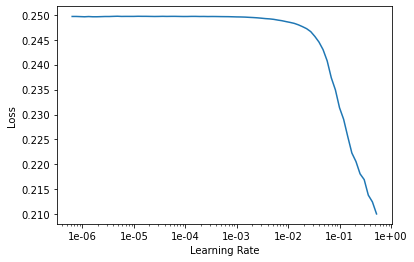

In [424]:
learn = collab_learner(data, n_factors=40, y_range=[0,1.0], wd=.1)
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [425]:
learn.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,time
0,0.246992,0.242341,00:00
1,0.211962,0.159682,00:00
2,0.154750,0.142484,00:00
3,0.121122,0.138941,00:00
4,0.100792,0.138515,00:00


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [434]:
#Defining users and items that 
(users, items), ratings = next(iter(data.valid_dl))

#Creating df to save prediction output
cf_real = []
cf_pred = []
cf_diff = []

preds = learn.model(users, items)
print('Real\tPred\tDifference')
for p in list(zip(ratings, preds))[:16]:
    print('{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[1]-p[0]))
    cf_real.append(p[0].item())
    cf_pred.append(p[1].item())
    cf_diff.append(p[1].item()-p[0].item())

#SAVING RESULTS TO DATAFRAME TO EXPORT LATER
pred_result = pd.DataFrame()
pred_result['Real'] = cf_real
pred_result['Pred'] = cf_pred
pred_result['Diff'] = cf_diff
pred_result

[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


Real	Pred	Difference
1.0	0.9	-0.1
1.0	0.9	-0.1
1.0	1.0	-0.0
0.0	0.0	0.0
1.0	0.9	-0.1
1.0	0.4	-0.6
0.0	0.2	0.2
0.0	0.1	0.1
0.0	0.0	0.0
1.0	0.4	-0.6
0.0	0.1	0.1
0.0	0.1	0.1
0.0	0.1	0.1
0.0	0.1	0.1
0.0	0.1	0.1
0.0	0.4	0.4


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


,Real,Pred,Diff
0,1.0,0.913999,-0.086001
1,1.0,0.881904,-0.118096
2,1.0,0.953849,-0.046151
3,0.0,0.022430,0.022430
4,1.0,0.878474,-0.121526
5,1.0,0.440175,-0.559825
6,0.0,0.214943,0.214943
7,0.0,0.067003,0.067003
8,0.0,0.035658,0.035658
9,1.0,0.386997,-0.613003


In [442]:
#Shows the set of tensors that the model is trying to use predict for
print(users)
cf_item = []
cf_user = []
for i in items[:16]:
    cf_item.append(i.item())
for i in users[:16]:
    cf_user.append(i.item())

pred_result['veg_id'] = cf_item
pred_result['id'] = cf_user
pred_result

tensor([156, 156,  90, 110, 115,  37, 166, 102, 103,  47, 121,  19, 133, 153,
         99, 116, 141, 101, 118,  21,  64,  16,  45, 152,   1,  15,  21,  86,
        164, 161,  64,  19,  93, 134, 130, 167, 115, 138, 114,  52, 137,  72,
        102,  28,  93,  53,  23, 150, 114, 165,  36, 129, 147,  21,  43, 150,
        145,  17, 117, 128, 143,  81,  43,  46])


,Real,Pred,Diff,veg_id,id
0,1.0,0.913999,-0.086001,2,156
1,1.0,0.881904,-0.118096,5,156
2,1.0,0.953849,-0.046151,5,90
3,0.0,0.022430,0.022430,10,110
4,1.0,0.878474,-0.121526,5,115
5,1.0,0.440175,-0.559825,11,37
6,0.0,0.214943,0.214943,29,166
7,0.0,0.067003,0.067003,18,102
8,0.0,0.035658,0.035658,26,103
9,1.0,0.386997,-0.613003,19,47


In [ ]:
user = tensor([47,47,47,47,47,47])
item = tensor([1,2,3,4,5,6])
item
preds = learn.model(user, item)
preds

tensor([0.1345, 0.8338, 0.8465, 0.8035, 0.7441, 0.6874],
       grad_fn=<AddBackward0>)

In [ ]:
item = tensor([ 1, 2,  3])
user = tensor([ 47,  47,  47])

In [ ]:
preds = learn.model(user, item)
preds

tensor([0.1345, 0.8338, 0.8465], grad_fn=<AddBackward0>)

In [ ]:
cf_data[cf_data['id']=='47']

,id,veg_id,like
176,47,5,1
266,47,4,1
604,47,12,1
679,47,6,1
758,47,16,1
3800,47,25,0


### Categorizing the TV Shows into genres using TheMovieDB API
#### (Leveraging this for future analysis and demographic breakdown)

In [ ]:
#Dependencies for API
import requests
import json

from api_key import movie_api

In [ ]:
shows = survey_df["tv_show"].tolist()
print(shows)

['FIREFLY', 'VINCENZO', 'TED LASSO', 'SUCCESSION', 'CRITICAL ROLE', 'GOSSIP GIRL', 'DEMON SLAYER', 'WEST WING', 'FRIENDS', 'NCIS', 'NCIS', 'THE OFFICE', 'TOP CHEF', 'OUTLANDER', 'NEW GIRL', 'TWIN PEAKS', 'STRANGER THINGS', 'NONE', 'CHICAGO MED', 'NEW GIRL', 'BATTLEBOTS', 'BREAKING BAD', 'FAMILY FEUD ', 'CHICAGO MED, FIRE, PD', 'THE OFFICE', 'RICK AND MORTY', "HELL'S KITCHEN ", 'BOB’S BURGERS', 'THIS IS US', 'SPORTS', 'DANCING WITH THE STARS', 'HOW I MET YOUR MOTHER', 'GREY’S ANATOMY ', 'OUR FLAG MEANS DEATH', 'CHICAGO SERIES', 'FRIENDS', 'HANNIBAL', 'STRANGER THINGS', 'NOVA', 'CHICAGO FIRE', 'THE BOYS', 'THE OFFICE', "SCHITT'S CREEK", 'STAR TREK ', 'THE OFFICE', 'MONDAY NIGHT FOOTBALL ', 'CHICAGO PD', 'BLACKLIST', 'STATION ELEVEN', 'THE FIRST LADY', 'JEOPARDY ', 'HGTV SHOWS', 'WALKING DEAD', 'YOU', 'ALL AMERICAN ', 'COSBY SHOW', 'STRANGER THINGS', 'THE L WORD', 'THE WIRE', 'FIREFLY', "I DON'T HAVE ONE", 'THE SIMPSONS', 'SUPERNATURAL', 'FRIENDS ', 'JANE THE VIRGIN ', 'DATELINE', 'STRANG

In [ ]:
tv_url = "https://api.themoviedb.org/3/search/tv?api_key="+movie_api

ids = []
titles = []
genre_id = []
test = []
broken = []

for tv in shows:
    search = requests.get(tv_url + "&query="+tv).json()
    # search = requests.get(movie_url + "&query= CRITICAL ROLE").json()
    try:
        tv_id = search['results'][0]['id']
        titles.append(tv)
            
    except:
        broken.append(tv)
        print(f"'{tv}' failed again")

'CHICAGO MED, FIRE, PD' failed again
'CHICAGO SERIES' failed again
'HGTV SHOWS' failed again
'I DON'T HAVE ONE' failed again
'THE SAPRANOS' failed again
'I DON'T HAVE ONE ' failed again
'EVERYONE LOVES RAYMOND' failed again
'MILWAUKEE BREWERS PREGAME' failed again
'GRAYS ANATOMY ' failed again
'NO CURRENT FAVORITE' failed again
'GRAYS ANATOMY ' failed again
'THE CBS MORNING SHOW' failed again
'RIGHT NOW STANGERS THINGS' failed again
'AVATAR THE LAST AIR BENDER' failed again
'SCORPIANS' failed again
'I DON’T HAVE ONE ' failed again
'ROCK THE PARK, PET RESCUE' failed again
'NO SPECIFIC SHOW - I LIKE MURDER MYSTERIES, FOOD NETWORK CHAMPIONSHIP COOKING CONTESTS, ROM-COMS, ETC.  ' failed again
'DON'T HAVE ONE' failed again


In [ ]:
# REPLACING TYPOS AND RESULTS THAT WERE NOT A SINGLE SHOW
survey_df["tv_show"] = survey_df["tv_show"].replace(['CHICAGO MED, FIRE, PD', 'CHICAGO SERIES'],['CHICAGO MED','CHICAGO MED'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['HGTV SHOWS'],['FIXER UPPER'])
survey_df["tv_show"] = survey_df["tv_show"].replace(["I DON'T HAVE ONE","I DON'T HAVE ONE "],['NONE','NONE'])
survey_df["tv_show"] = survey_df["tv_show"].replace(["I DON’T WATCH TV"],['NONE'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['THE SAPRANOS'],['THE SOPRANOS'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['EVERYONE LOVES RAYMOND'],['EVERYBODY LOVES RAYMOND'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['MILWAUKEE BREWERS PREGAME'],['THURSDAY NIGHT BASEBALL'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['NO CURRENT FAVORITE'],['NONE'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['GRAYS ANATOMY '],["GREY'S ANATOMY"])
survey_df["tv_show"] = survey_df["tv_show"].replace(['THE CBS MORNING SHOW'],['CBS MORNING NEWS'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['RIGHT NOW STANGERS THINGS'],['STRANGER THINGS'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['AVATAR THE LAST AIR BENDER'],['AVATAR: THE LAST AIRBENDER'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['SCORPIANS'],['SCORPION'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['ROCK THE PARK, PET RESCUE'],['ROCK THE PARK'])
survey_df["tv_show"] = survey_df["tv_show"].replace(['NO SPECIFIC SHOW - I LIKE MURDER MYSTERIES, FOOD NETWORK CHAMPIONSHIP COOKING CONTESTS, ROM-COMS, ETC.  '],['THE AFTER PARTY'])
survey_df["tv_show"] = survey_df["tv_show"].replace(["DON'T HAVE ONE",'I DON’T HAVE ONE '],['NONE','NONE'])
shows = survey_df["tv_show"].to_list()
print(shows)

['FIREFLY', 'VINCENZO', 'TED LASSO', 'SUCCESSION', 'CRITICAL ROLE', 'GOSSIP GIRL', 'DEMON SLAYER', 'WEST WING', 'FRIENDS', 'NCIS', 'NCIS', 'THE OFFICE', 'TOP CHEF', 'OUTLANDER', 'NEW GIRL', 'TWIN PEAKS', 'STRANGER THINGS', 'NONE', 'CHICAGO MED', 'NEW GIRL', 'BATTLEBOTS', 'BREAKING BAD', 'FAMILY FEUD ', 'CHICAGO MED', 'THE OFFICE', 'RICK AND MORTY', "HELL'S KITCHEN ", 'BOB’S BURGERS', 'THIS IS US', 'SPORTS', 'DANCING WITH THE STARS', 'HOW I MET YOUR MOTHER', 'GREY’S ANATOMY ', 'OUR FLAG MEANS DEATH', 'CHICAGO MED', 'FRIENDS', 'HANNIBAL', 'STRANGER THINGS', 'NOVA', 'CHICAGO FIRE', 'THE BOYS', 'THE OFFICE', "SCHITT'S CREEK", 'STAR TREK ', 'THE OFFICE', 'MONDAY NIGHT FOOTBALL ', 'CHICAGO PD', 'BLACKLIST', 'STATION ELEVEN', 'THE FIRST LADY', 'JEOPARDY ', 'FIXER UPPER', 'WALKING DEAD', 'YOU', 'ALL AMERICAN ', 'COSBY SHOW', 'STRANGER THINGS', 'THE L WORD', 'THE WIRE', 'FIREFLY', 'NONE', 'THE SIMPSONS', 'SUPERNATURAL', 'FRIENDS ', 'JANE THE VIRGIN ', 'DATELINE', 'STRANGER THINGS', 'SEINFELD', 

In [ ]:
#RUNNING API AGAIN WITH CLEAN TV SHOW LIST
tv_url = "https://api.themoviedb.org/3/search/tv?api_key="+movie_api

ids = []
titles = []
genre_id = []
test = []
broken = []

for tv in shows:
    search = requests.get(tv_url + "&query="+tv).json()
    # search = requests.get(movie_url + "&query= CRITICAL ROLE").json()
    try:
        tv_id = search['results'][0]['id']
        titles.append(tv)
        #APPENDING GENRE IDS TO GENRE DF OUTSIDE OF FOR LOOP
        genres = search['results'][0]['genre_ids']
        genre_id.append(genres)
            
    except:
        broken.append(tv)
        print(f"'{tv}' failed again")

In [ ]:
#CREATING A GENRE DICTIONARY DATAFRAME
genre_url = "https://api.themoviedb.org/3/genre/tv/list?api_key="+movie_api
search = requests.get(genre_url).json()

genre_dict = pd.DataFrame(search['genres'])
genre_dict = genre_dict.reset_index(drop=True)
genre_dict = genre_dict.set_index('id')
genre_dict

,name
id,
10759,Action & Adventure
16,Animation
35,Comedy
80,Crime
99,Documentary
18,Drama
10751,Family
10762,Kids
9648,Mystery


In [468]:
genre_names = []

genre_names

for item in survey_df['genre_ids']:
    name = []
    for i in range(0,len(item)):
        name.append(genre_dict.loc[item[i]].values.item())
    genre_names.append(name)

In [471]:
survey_df['genre_ids'] = genre_id
survey_df['genre_names'] = genre_names

genres = survey_df["genre_names"]
genres

0      [Drama, Action & Adventure, Sci-Fi & Fantasy]
1                [Action & Adventure, Comedy, Drama]
2                                           [Comedy]
3                                    [Drama, Comedy]
4                                 [Sci-Fi & Fantasy]
                           ...                      
170                                        [Reality]
171                                         [Comedy]
172                                  [Comedy, Drama]
173                                   [Talk, Comedy]
174                                           [News]
Name: genre_names, Length: 175, dtype: object

# EXPORT RESULTS TO EXCEL CSV

In [445]:
#EXPORTING CLEANED DATA TO CSV FOR TABLEAU
survey_df.to_csv("survey_results_cleaned.csv")

#EXPORTING PREDICTIONS FROM COLLABORATIVE FILTERING
pred_result.to_csv("collab_predictions.csv")